In [1]:
import warnings, os
import numpy as np
import pandas as pd
from nbeats_keras.model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [4]:
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data

def real_data_loading (data_name):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  

  assert data_name in ['stock','energy']

  if data_name == 'stock':
    ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
      ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  return ori_data

In [5]:
num_samples, time_steps, input_dim, output_dim = 50_000, 15, 28, 28
backend = NBeatsKeras(
        input_dim=input_dim,
        backcast_length=time_steps, forecast_length=5,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', optimizer='adam')

forecast_length = 5
backcast_length = 3 * forecast_length

'''
milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity. milk.shape = 168
'''

data_name = "energy"
#seq_len = 24 # or the whole length: 19735
ori_data = real_data_loading(data_name) # 
ori_data = np.asarray(ori_data)
#ori_data = ori_data[:,:,:20]
print("real data shape:", ori_data.shape) # (no, seq_len, dim)

# x: data backcast/y: forecast generation.
x, y = [], []
for epoch in range(backcast_length, len(ori_data) - forecast_length): # range(15, len-5):
    x.append(ori_data[epoch - backcast_length:epoch]) # x = backcast (0,15), (1,16)
    y.append(ori_data[epoch:epoch + forecast_length]) # y = forecast (15,20), (16,21)
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
# print("the c size is: ", c) # c = 118
x_train, y_train = x[:c], y[:c] # cut the first part to be training samples (80%)
x_test, y_test = x[c:], y[c:] # use the rest part to be testing samples (20%)

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant
test_size = len(x_test)
# print("test_size is:", test_size) # test_size = 30

real data shape: (19735, 28)


In [6]:
# check the model data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15772, 15, 28), (15772, 5, 28), (3943, 15, 28), (3943, 5, 28))

In [7]:
# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_split=0.2, epochs=1000, batch_size=128)

# Save the model for later.
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
print("the prediction_forecast shape is:", predictions_forecast.shape) #shape: (30, 5, 1)
#np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
print("the prediction_backcast shape is:", predictions_backcast.shape) #shape: (30, 15, 1)
#np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model.h5')
predicts = model_2.predict(x_test)
print("the reloaded prediction_shape is:", predicts.shape) #shape: (30, 5, 1)
#np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/1000
99/99 [==============================] - 75s 202ms/step - loss: 0.2392 - val_loss: 0.1824
Epoch 2/1000
99/99 [==============================] - 2s 16ms/step - loss: 0.1837 - val_loss: 0.1856
Epoch 3/1000
99/99 [==============================] - 2s 17ms/step - loss: 0.1832 - val_loss: 0.1839
Epoch 4/1000
99/99 [==============================] - 2s 15ms/step - loss: 0.1817 - val_loss: 0.1790
Epoch 5/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1812 - val_loss: 0.1810
Epoch 6/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1816 - val_loss: 0.1783
Epoch 7/1000
99/99 [==============================] - 2s 15ms/step - loss: 0.1814 - val_loss: 0.1834
Epoch 8/1000
99/99 [==============================] - 2s 15ms/step - loss: 0.1816 - val_loss: 0.1812
Epoch 9/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1802 - val_loss: 0.1815
Epoch 10/1000
99/99 [==============================] - 1s 15ms/step - loss: 0

99/99 [==============================] - 1s 15ms/step - loss: 0.1685 - val_loss: 0.1878
Epoch 82/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1679 - val_loss: 0.1924
Epoch 83/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1683 - val_loss: 0.1909
Epoch 84/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1682 - val_loss: 0.1894
Epoch 85/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1679 - val_loss: 0.1911
Epoch 86/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1680 - val_loss: 0.1902
Epoch 87/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1678 - val_loss: 0.1885
Epoch 88/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1680 - val_loss: 0.1946
Epoch 89/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1680 - val_loss: 0.1924
Epoch 90/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1680 - val_loss: 0

Epoch 161/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1648 - val_loss: 0.1933
Epoch 162/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1645 - val_loss: 0.1967
Epoch 163/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1649 - val_loss: 0.1924
Epoch 164/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1655 - val_loss: 0.1952
Epoch 165/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1648 - val_loss: 0.1945
Epoch 166/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1650 - val_loss: 0.1946
Epoch 167/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1650 - val_loss: 0.1925
Epoch 168/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1646 - val_loss: 0.1945
Epoch 169/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1647 - val_loss: 0.1943
Epoch 170/1000
99/99 [==============================] - 1s 12ms/step - lo

99/99 [==============================] - 1s 13ms/step - loss: 0.1645 - val_loss: 0.1967
Epoch 241/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1640 - val_loss: 0.1945
Epoch 242/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1640 - val_loss: 0.1936
Epoch 243/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1639 - val_loss: 0.1920
Epoch 244/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1646 - val_loss: 0.1944
Epoch 245/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1635 - val_loss: 0.1947
Epoch 246/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1635 - val_loss: 0.1940
Epoch 247/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1643 - val_loss: 0.1952
Epoch 248/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1641 - val_loss: 0.1956
Epoch 249/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.1638 - va

99/99 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1930
Epoch 320/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1641 - val_loss: 0.1947
Epoch 321/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1934
Epoch 322/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1640 - val_loss: 0.1970
Epoch 323/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1638 - val_loss: 0.1957
Epoch 324/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1635 - val_loss: 0.1950
Epoch 325/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1939
Epoch 326/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1639 - val_loss: 0.1937
Epoch 327/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1637 - val_loss: 0.1935
Epoch 328/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1637 - va

99/99 [==============================] - 1s 15ms/step - loss: 0.1635 - val_loss: 0.1947
Epoch 399/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1640 - val_loss: 0.1938
Epoch 400/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1633 - val_loss: 0.1945
Epoch 401/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1941
Epoch 402/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1933
Epoch 403/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1935
Epoch 404/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1634 - val_loss: 0.1941
Epoch 405/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1921
Epoch 406/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1634 - val_loss: 0.1932
Epoch 407/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1639 - va

99/99 [==============================] - 1s 14ms/step - loss: 0.1635 - val_loss: 0.1941
Epoch 478/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1630 - val_loss: 0.1943
Epoch 479/1000
99/99 [==============================] - 2s 16ms/step - loss: 0.1630 - val_loss: 0.1946
Epoch 480/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1632 - val_loss: 0.1921
Epoch 481/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1634 - val_loss: 0.1935
Epoch 482/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1629 - val_loss: 0.1916
Epoch 483/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1633 - val_loss: 0.1957
Epoch 484/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1951
Epoch 485/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1633 - val_loss: 0.1943
Epoch 486/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - va

99/99 [==============================] - 2s 16ms/step - loss: 0.1631 - val_loss: 0.1924
Epoch 557/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1632 - val_loss: 0.1945
Epoch 558/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1632 - val_loss: 0.1943
Epoch 559/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1925
Epoch 560/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1936
Epoch 561/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1627 - val_loss: 0.1930
Epoch 562/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1629 - val_loss: 0.1946
Epoch 563/1000
99/99 [==============================] - 2s 16ms/step - loss: 0.1629 - val_loss: 0.1920
Epoch 564/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1628 - val_loss: 0.1939
Epoch 565/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1632 - va

99/99 [==============================] - 1s 15ms/step - loss: 0.1630 - val_loss: 0.1959
Epoch 636/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1934
Epoch 637/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1630 - val_loss: 0.1941
Epoch 638/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - val_loss: 0.1939
Epoch 639/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1935
Epoch 640/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1933
Epoch 641/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1633 - val_loss: 0.1942
Epoch 642/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - val_loss: 0.1938
Epoch 643/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1627 - val_loss: 0.1927
Epoch 644/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1627 - va

99/99 [==============================] - 1s 15ms/step - loss: 0.1628 - val_loss: 0.1925
Epoch 715/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1634 - val_loss: 0.1951
Epoch 716/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1635 - val_loss: 0.1933
Epoch 717/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1632 - val_loss: 0.1923
Epoch 718/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1632 - val_loss: 0.1936
Epoch 719/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1630 - val_loss: 0.1941
Epoch 720/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1630 - val_loss: 0.1928
Epoch 721/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1633 - val_loss: 0.1942
Epoch 722/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - val_loss: 0.1926
Epoch 723/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.1631 - va

99/99 [==============================] - 1s 14ms/step - loss: 0.1626 - val_loss: 0.1928
Epoch 794/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1625 - val_loss: 0.1913
Epoch 795/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1630 - val_loss: 0.1934
Epoch 796/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1624 - val_loss: 0.1946
Epoch 797/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1928
Epoch 798/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1928
Epoch 799/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - val_loss: 0.1913
Epoch 800/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1634 - val_loss: 0.1936
Epoch 801/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1630 - val_loss: 0.1915
Epoch 802/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1631 - va

99/99 [==============================] - 1s 14ms/step - loss: 0.1626 - val_loss: 0.1933
Epoch 873/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1627 - val_loss: 0.1943
Epoch 874/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1627 - val_loss: 0.1916
Epoch 875/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1626 - val_loss: 0.1928
Epoch 876/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1922
Epoch 877/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1632 - val_loss: 0.1928
Epoch 878/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1934
Epoch 879/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1628 - val_loss: 0.1935
Epoch 880/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1627 - val_loss: 0.1939
Epoch 881/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - va

99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1933
Epoch 952/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1634 - val_loss: 0.1923
Epoch 953/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - val_loss: 0.1942
Epoch 954/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1629 - val_loss: 0.1924
Epoch 955/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1621 - val_loss: 0.1928
Epoch 956/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1628 - val_loss: 0.1930
Epoch 957/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1627 - val_loss: 0.1923
Epoch 958/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1631 - val_loss: 0.1935
Epoch 959/1000
99/99 [==============================] - 1s 14ms/step - loss: 0.1633 - val_loss: 0.1919
Epoch 960/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.1630 - va

/home/stufs1/zuwang/anaconda3/envs/nbeats/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


the prediction_forecast shape is: (3943, 5, 28)
the prediction_backcast shape is: (3943, 15, 28)
the reloaded prediction_shape is: (3943, 5, 28)


In [8]:
predicts.shape, y_test.shape

((3943, 5, 28), (3943, 5, 28))

In [9]:
predicts[0].shape, y_test[0].shape

((5, 28), (5, 28))

In [10]:
mean_absolute_error(predicts[0], y_test[0])

0.20377246835290805

In [11]:
num_sample = len(x_test)

MAE_temp = 0.0
MSE_temp = 0.0

for i in range(num_sample):
    MAE_temp = MAE_temp + mean_absolute_error(y_test[i], predicts[i])
    MSE_temp = MSE_temp + mean_squared_error(y_test[i], predicts[i])

predictive_score_mae = MAE_temp/num_sample
predictive_score_mse = MSE_temp/num_sample
print("predictive_score_mae:", predictive_score_mae)
print("predictive_score_mse:", predictive_score_mse)

predictive_score_mae: 0.22706413988513136
predictive_score_mse: 0.07520019965609484


In [12]:
predicts[0].shape

(5, 28)

In [13]:
ff, xx, yy = predicts[0] * norm_constant, x_test[0] * norm_constant, y_test[0] * norm_constant
ff.shape, xx.shape, yy.shape

((5, 28), (15, 28), (5, 28))

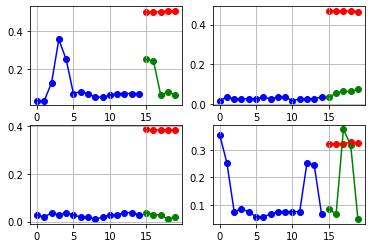

In [15]:
subplots = [221, 222, 223, 224]
plt.figure(1)
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    p1 = np.expand_dims(predicts[i][:,0], axis=-1)
    x1 = np.expand_dims(x_test[i][:,0], axis=-1)
    y1 = np.expand_dims(y_test[i][:,0], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.savefig("nbeats-REAL-predictions-energy.png", dpi=300)
plt.show()